<a href="https://colab.research.google.com/github/lrodrigocareaga/practice/blob/master/SatelliteImagesDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



  # Experiments
## Luis Rodrigo Careaga Sotomayor

# Libraries needed

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

#Sci-kit libraries
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

#Others
import time
import matplotlib.image as mpimg
import skimage
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

## Google Drive/Colab

In [0]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Kaggle Import

In [0]:
#import kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"rodrigocareaga","key":"e91114f4a8647f46ce0ee3b423ffca5b"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


!pip install -q kaggle
!pip install -q kaggle-cli

#see the possible datasets in kaggle
!kaggle datasets list
#see the possible competitions in kaggle
!kaggle competitions list

total 4
-rw------- 1 root root 70 Apr 27 15:36 kaggle.json
    100% |████████████████████████████████| 81kB 3.8MB/s 
    100% |████████████████████████████████| 5.3MB 6.4MB/s 
    100% |████████████████████████████████| 51kB 24.0MB/s 
    100% |████████████████████████████████| 102kB 33.4MB/s 
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          35697  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          24435  
karangadiya/fifa19                                           FIFA 19 complete

In [0]:
!kaggle datasets list -s crawford/deepsat-sat6
!kaggle datasets download crawford/deepsat-sat6


No datasets found
 99% 2.40G/2.42G [00:25<00:00, 156MB/s]
100% 2.42G/2.42G [00:25<00:00, 101MB/s]


In [0]:
os.chdir('/content/drive/My Drive/')
for file in os.listdir():
  if file.endswith("csv.zip"):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('deepsat-sat6.zip', 'r')
zip_ref.extractall()
zip_ref.close()

# Hyperpameter Tuning

### Regularization

#### Dropout

In [0]:
dropout_10 = layers.Dropout(0.1,
               noise_shape=None,
               seed=1)

In [0]:
dropout_20 = layers.Dropout(0.2,
               noise_shape=None,
               seed=1)

In [0]:
dropout_50 = layers.Dropout(0.5,
               noise_shape=None,
               seed=1)

#### Lasso Regression

In [0]:
l1_reg10 = keras.regularizers.l1(0.1)

In [0]:
l1_reg20 = keras.regularizers.l1(0.2)

#### Ridge Regression

In [0]:
l2_reg10 = keras.regularizers.l2(0.1)

In [0]:
l2_reg20 = keras.regularizers.l2(0.2)

#### Lasso & Ridge

In [0]:
l1l2_reg = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

### Batch Normalization

In [0]:
batch_normalization = layers.BatchNormalization(axis=-1, 
                                                momentum=0.999, 
                                                epsilon=0.0001, 
                                                center=True, 
                                                scale=True,
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones',
                                                beta_regularizer=None, 
                                                gamma_regularizer=None,
                                                beta_constraint=None,
                                                gamma_constraint=None)

### Custom Optimizers

In [0]:
adam_opt=optimizers.Adam(lr=0.0001,
                   beta_1=0.9, 
                   beta_2=0.999,
                   epsilon=None,
                   decay=0.0,
                   amsgrad=False)

In [0]:
adadelta_opt = optimizers.Adagrad(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

In [0]:
adadelta_opt = optimizers.Adadelta(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

### Custom Activation Functions

In [0]:
leakyReLU_act = layers.LeakyReLU(alpha=0.3)

In [0]:
pReLU_act = layers.PReLU(alpha_initializer='zeros',
                         alpha_regularizer=None, 
                         alpha_constraint=None,
                         shared_axes=None)

In [0]:
elu_act = layers.ELU(alpha=1.0)

# SAT-4

## Dataset SAT-4

Dataset retrieved from 

In [0]:
x_train_set_fpath = 'X_train_sat4.csv'
y_train_set_fpath = 'y_train_sat4.csv'
print ('Loading Training Data')
X_train = pd.read_csv(x_train_set_fpath, nrows=100000)
print ('Loaded 28 x 28 x 4 images')
y_train = pd.read_csv(y_train_set_fpath,nrows=100000)
print ('Loaded labels')

Loading Training Data
Loaded 28 x 28 x 4 images
Loaded labels


In [0]:
x_test_set_fpath = 'X_test_sat4.csv'
y_test_set_fpath = 'y_test_sat4.csv'
print ('Loading Testing Data')
X_test = pd.read_csv(x_test_set_fpath, nrows=20000)
print ('Loaded 28 x 28 x 4 images')
y_test = pd.read_csv(y_test_set_fpath,nrows=20000)
print ('Loaded labels')

Loading Testing Data
Loaded 28 x 28 x 4 images
Loaded labels


In [0]:
X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()
print ('We have',X_train.shape[0],'examples and each example is a list of',X_train.shape[1],'numbers with',y_train.shape[1],'possible classifications.')

We have 100000 examples and each example is a list of 3136 numbers with 4 possible classifications.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
#First we have to reshape each of them from a list of numbers to a 28*28*4 image.
X_train_img = X_train.reshape([100000,28,28,4]).astype(float)
X_test_img = X_test.reshape([20000,28,28,4]).astype(float)
print (X_train_img.shape)
print (X_test_img.shape)


y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print (y_train_cat.shape)
print (y_test_cat.shape)

(100000, 28, 28, 4)
(20000, 28, 28, 4)
(100000, 4, 2)
(20000, 4, 2)


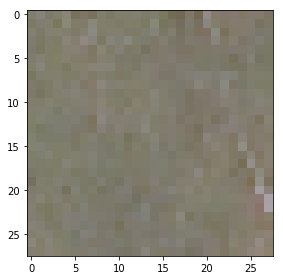

Grassland


In [0]:
class_names = ['Barren Land','Trees','Grassland','Other']

#Type a number between 0 and 99,999 inclusive
ix = 23351
imshow(np.squeeze(X_train_img[ix,:,:,0:3]).astype(np.uint8))
plt.show()

if y_train[ix,0] == 1:
    print ('Barren Land')
elif y_train[ix,1] == 1:
    print ('Trees')
elif y_train[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [0]:
X_train = X_train/255
X_test = X_test/255
X_train_img_norm = X_train_img/255

## Traditional Neural Network

In [0]:
modelDense = Sequential([
    Dense(1500, input_shape=(3136,), activation='relu'),
    Dense(700, input_shape=(3136,), activation='relu'),
    Dense(4, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
modelDense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.clock() 
historyDense = modelDense.fit(X_train,y_train,batch_size=64, epochs=30, verbose=1, validation_split=0.1)

end = time.clock()
timeDense = end-start

print("Total Time: {} ".format(timeDense)) 

Instructions for updating:
Use tf.cast instead.
Train on 90000 samples, validate on 10000 samples
Epoch 1/20
90000/90000 [==============================] - 36s 396us/step - loss: 0.9192 - acc: 0.7201 - val_loss: 0.5056 - val_acc: 0.7972
Epoch 2/20
90000/90000 [==============================] - 33s 362us/step - loss: 0.4958 - acc: 0.7987 - val_loss: 0.4276 - val_acc: 0.8283
Epoch 3/20
90000/90000 [==============================] - 32s 361us/step - loss: 0.4426 - acc: 0.8231 - val_loss: 0.4087 - val_acc: 0.8383
Epoch 4/20
90000/90000 [==============================] - 32s 358us/step - loss: 0.4023 - acc: 0.8414 - val_loss: 0.4982 - val_acc: 0.7729
Epoch 5/20
90000/90000 [==============================] - 33s 367us/step - loss: 0.3774 - acc: 0.8552 - val_loss: 0.4117 - val_acc: 0.8365
Epoch 6/20
90000/90000 [==============================] - 32s 360us/step - loss: 0.3565 - acc: 0.8649 - val_loss: 0.3362 - val_acc: 0.8752
Epoch 7/20
90000/90000 [==============================] - 33s 362us/

In [0]:
test_lossDense, test_accDense = modelDense.evaluate(X_test, y_test)
print('Test loss:',test_lossDense)
print('Test accuracy:', test_accDense)

# Predicting the Test set results
y_predDense = modelDense.predict(X_test, verbose=1)


20000/20000 [==============================] - 2s 121us/step
Test loss: 0.2788029425740242
Test accuracy: 0.8953
20000/20000 [==============================] - 2s 117us/step


### Metrics and Visualization NN

In [0]:
plot_model(modelDense, to_file='modelDenseSat4.png')
modelDense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1500)              4705500   
_________________________________________________________________
dense_2 (Dense)              (None, 700)               1050700   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2804      
Total params: 5,759,004
Trainable params: 5,759,004
Non-trainable params: 0
_________________________________________________________________


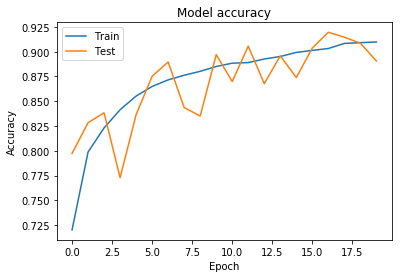

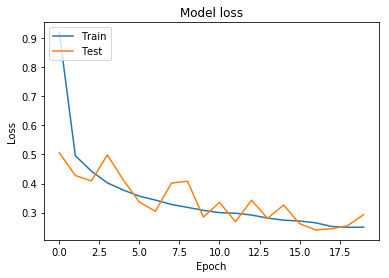

In [0]:
# Plot training & validation accuracy values
plt.plot(historyDense.history['acc'])
plt.plot(historyDense.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyDense.history['loss'])
plt.plot(historyDense.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[5031    6   95   87]
 [   0 3781   89  203]
 [  70  313 2900  366]
 [  92  497  276 6194]]
Normalized confusion matrix
[[0.96 0.   0.02 0.02]
 [0.   0.93 0.02 0.05]
 [0.02 0.09 0.79 0.1 ]
 [0.01 0.07 0.04 0.88]]


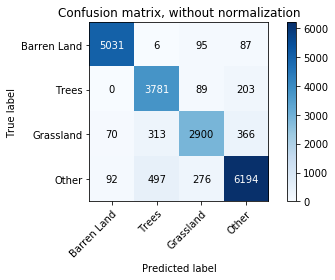

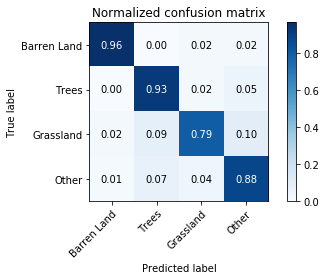

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_predDense, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_predDense, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
predicted_classes = np.argmax((y_predDense),axis=1)
y_test1 = np.argmax(y_test, axis=1)
predicted_classes.shape, y_test.shape
print(classification_report(y_test1, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

 Barren Land       0.97      0.96      0.97      5219
       Trees       0.82      0.93      0.87      4073
   Grassland       0.86      0.79      0.83      3649
       Other       0.90      0.88      0.89      7059

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.90      0.90      0.90     20000



In [0]:
keras.backend.clear_session()

## Convolutional Neural Network

In [0]:
modelConv = Sequential()

modelConv.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,4)))
modelConv.add(layers.LeakyReLU(alpha=0.1))
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D((2, 2),padding='same'))
modelConv.add(Dropout(0.25))
modelConv.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
modelConv.add(layers.LeakyReLU(alpha=0.1))
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv.add(Dropout(0.25))
modelConv.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
modelConv.add(layers.LeakyReLU(alpha=0.1))                
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv.add(Dropout(0.4))
modelConv.add(Flatten())
modelConv.add(Dense(128, activation='linear'))
modelConv.add(layers.LeakyReLU(alpha=0.1))           
modelConv.add(BatchNormalization())
modelConv.add(Dropout(0.3))
modelConv.add(Dense(4, activation='softmax'))

In [0]:
modelConv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.clock() 
historyConv = modelConv.fit(X_train_img,y_train,batch_size=64, epochs=20, verbose=1, validation_split=0.1)


end = time.clock()
timeConv = end-start

print("Total Time: {} ".format(timeConv)) 

Train on 90000 samples, validate on 10000 samples
Epoch 1/20
90000/90000 [==============================] - 38s 424us/step - loss: 0.1635 - acc: 0.9443 - val_loss: 0.4047 - val_acc: 0.8560
Epoch 2/20
90000/90000 [==============================] - 36s 402us/step - loss: 0.0874 - acc: 0.9706 - val_loss: 0.1957 - val_acc: 0.9349
Epoch 3/20
90000/90000 [==============================] - 36s 405us/step - loss: 0.0687 - acc: 0.9773 - val_loss: 0.5535 - val_acc: 0.8566
Epoch 4/20
90000/90000 [==============================] - 37s 406us/step - loss: 0.0581 - acc: 0.9810 - val_loss: 0.3788 - val_acc: 0.8671
Epoch 5/20
90000/90000 [==============================] - 36s 404us/step - loss: 0.0529 - acc: 0.9828 - val_loss: 0.3551 - val_acc: 0.9096
Epoch 6/20
90000/90000 [==============================] - 37s 408us/step - loss: 0.0496 - acc: 0.9839 - val_loss: 0.2501 - val_acc: 0.9340
Epoch 7/20
90000/90000 [==============================] - 37s 410us/step - loss: 0.0455 - acc: 0.9855 - val_loss: 2.

In [0]:
test_lossConv, test_accConv = modelConv.evaluate(X_test_img, y_test)
print('Test loss:',test_lossConv)
print('Test accuracy:', test_accConv)

# Predicting the Test set results
y_predConv = modelConv.predict(X_test_img, verbose=1)



20000/20000 [==============================] - 3s 161us/step
Test loss: 0.6477434497654438
Test accuracy: 0.84785
20000/20000 [==============================] - 3s 158us/step


In [0]:
ix = 235
plt.imshow(X_test[ix].reshape(28,28,4), cmap='gray', interpolation='none')
plt.show()
#Tells what the image is
print ('Prediction:\n{:.1f}% probability barren land,\n{:.1f}% probability trees,\n{:.1f}% probability grassland,\n{:.1f}% probability other\n'.format(y_predConv[ix,0]*100,y_predConv[ix,1]*100,y_predConv[ix,2]*100,y_predConv[ix,3]*100))

print ('Ground Truth: ',end='')
if y_train[99999-(1000-ix),0] == 1:
    print ('Barren Land')
elif y_train[99999-(1000-ix),1] == 1:
    print ('Trees')
elif y_train[99999-(1000-ix),2] == 1:
    print ('Grassland')
else:
    print ('Other')

### Metrics and Visualization NN

In [0]:
plot_model(modelConv, to_file='modelConvSat4.png')
modelConv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

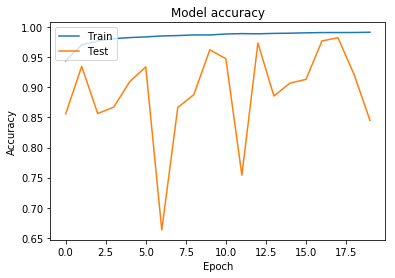

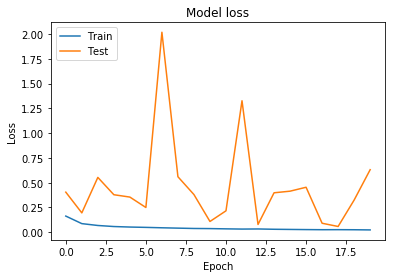

In [0]:
# Plot training & validation accuracy values
plt.plot(historyConv.history['acc'])
plt.plot(historyConv.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyConv.history['loss'])
plt.plot(historyConv.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[4776    0  442    1]
 [   1 3780  292    0]
 [ 331    2 3316    0]
 [ 569   36 1369 5085]]
Normalized confusion matrix
[[9.15e-01 0.00e+00 8.47e-02 1.92e-04]
 [2.46e-04 9.28e-01 7.17e-02 0.00e+00]
 [9.07e-02 5.48e-04 9.09e-01 0.00e+00]
 [8.06e-02 5.10e-03 1.94e-01 7.20e-01]]


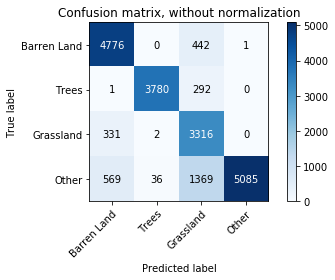

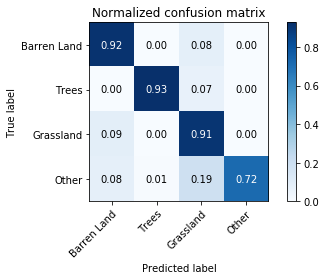

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_predConv, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_predConv, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
predicted_classes = np.argmax((y_predConv),axis=1)
y_test1 = np.argmax(y_test, axis=1)
predicted_classes.shape, y_test.shape
print(classification_report(y_test1, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

 Barren Land       0.84      0.92      0.88      5219
       Trees       0.99      0.93      0.96      4073
   Grassland       0.61      0.91      0.73      3649
       Other       1.00      0.72      0.84      7059

   micro avg       0.85      0.85      0.85     20000
   macro avg       0.86      0.87      0.85     20000
weighted avg       0.89      0.85      0.85     20000



In [0]:
keras.backend.clear_session()

## Comparison

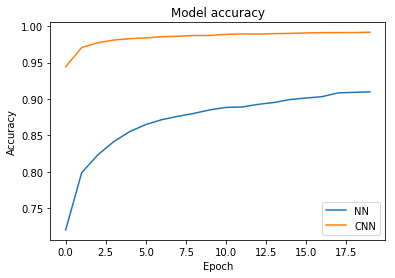

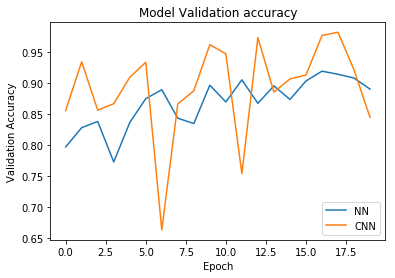

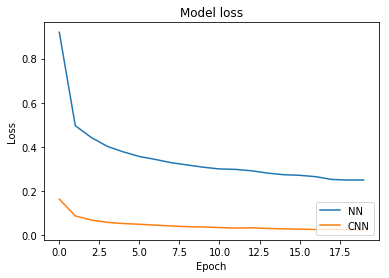

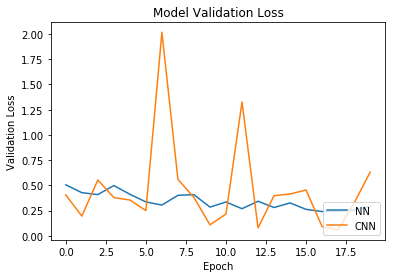

In [0]:
plt.plot(historyDense.history['acc'], label='NN')
plt.plot(historyConv.history['acc'], label='CNN')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()



plt.plot(historyDense.history['val_acc'], label='NN')
plt.plot(historyConv.history['val_acc'], label='CNN')


plt.title('Model Validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyDense.history['loss'], label='NN')
plt.plot(historyConv.history['loss'], label='CNN')


plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyDense.history['val_loss'], label='NN')
plt.plot(historyConv.history['val_loss'], label='CNN')


plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()




# SAT-6

## Dataset SAT-6

In [0]:
x_train_set_fpath = 'X_train_sat6.csv'
y_train_set_fpath = 'y_train_sat6.csv'
print ('Loading Training Data')
X_train = pd.read_csv(x_train_set_fpath, nrows=100000)
print ('Loaded 28 x 28 x 4 images')
y_train = pd.read_csv(y_train_set_fpath,nrows=100000)
print ('Loaded labels')

Loading Training Data
Loaded 28 x 28 x 4 images
Loaded labels


In [0]:
x_test_set_fpath = 'X_test_sat6.csv'
y_test_set_fpath = 'y_test_sat6.csv'
print ('Loading Testing Data')
X_test = pd.read_csv(x_test_set_fpath, nrows=20000)
print ('Loaded 28 x 28 x 4 images')
y_test = pd.read_csv(y_test_set_fpath,nrows=20000)
print ('Loaded labels')

Loading Testing Data
Loaded 28 x 28 x 4 images
Loaded labels


In [0]:
X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()
print ('We have',X_train.shape[0],'examples and each example is a list of',X_train.shape[1],'numbers with',y_train.shape[1],'possible classifications.')

We have 100000 examples and each example is a list of 3136 numbers with 6 possible classifications.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
#First we have to reshape each of them from a list of numbers to a 28*28*4 image.
X_train_img = X_train.reshape([100000,28,28,4]).astype(float)
X_test_img = X_test.reshape([20000,28,28,4]).astype(float)
print (X_train_img.shape)
print (X_test_img.shape)


y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print (y_train_cat.shape)
print (y_test_cat.shape)
class_names = ['Building','Barren Land','Trees','Grassland','Road','Water']

(100000, 28, 28, 4)
(20000, 28, 28, 4)
(100000, 6, 2)
(20000, 6, 2)


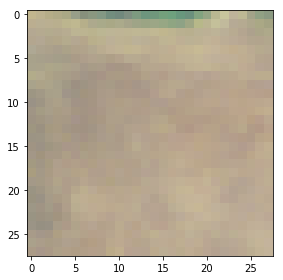

Barren land


In [0]:
#Let's take a look at one image. Keep in mind the channels are R,G,B, and I(Infrared)
ix = 25332#Type a number between 0 and 99,999 inclusive
imshow(np.squeeze(X_train_img[ix,:,:,0:3]).astype(np.uint8)) #Only seeing the RGB channels
plt.show()
#Tells what the image is
if y_train[ix,0] == 1:
    print ('Building')
elif y_train[ix,1] == 1:
    print ('Barren land')
elif y_train[ix,2] == 1:
    print ('Trees')
elif y_train[ix,3] == 1:
    print ('Grassland')
elif y_train[ix,4] == 1:
    print ('Road')

else:
    print ('Water')

In [0]:
X_train = X_train/255
X_test = X_test/255
X_train_img_norm = X_train_img/255

## Traditional Neural Network

In [0]:
modelDense = Sequential([
    Dense(64, input_shape=(3136,), activation='relu'),
    Dense(20, input_shape=(3136,), activation='relu'),
    Dense(6, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
modelDense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.clock() 
historyDense = modelDense.fit(X_train,y_train,batch_size=64, epochs=30, verbose=1, validation_split=0.1)
end = time.clock()
timeDense = end-start

print("Total Time: {} ".format(timeDense)) 

Instructions for updating:
Use tf.cast instead.
Train on 90000 samples, validate on 10000 samples
Epoch 1/30
90000/90000 [==============================] - 36s 405us/step - loss: 0.6867 - acc: 0.8508 - val_loss: 0.1937 - val_acc: 0.9194
Epoch 2/30
90000/90000 [==============================] - 33s 367us/step - loss: 0.2016 - acc: 0.9180 - val_loss: 0.1658 - val_acc: 0.9345
Epoch 3/30
90000/90000 [==============================] - 33s 366us/step - loss: 0.1745 - acc: 0.9299 - val_loss: 0.2540 - val_acc: 0.8822
Epoch 4/30
90000/90000 [==============================] - 33s 370us/step - loss: 0.1594 - acc: 0.9375 - val_loss: 0.1500 - val_acc: 0.9415
Epoch 5/30
90000/90000 [==============================] - 33s 367us/step - loss: 0.1479 - acc: 0.9426 - val_loss: 0.1967 - val_acc: 0.9212
Epoch 6/30
90000/90000 [==============================] - 33s 371us/step - loss: 0.1396 - acc: 0.9471 - val_loss: 0.1298 - val_acc: 0.9514
Epoch 7/30
90000/90000 [==============================] - 33s 370us/

In [0]:
test_lossDense, test_accDense = modelDense.evaluate(X_test, y_test)
print('Test loss:',test_lossDense)
print('Test accuracy:', test_accDense)

# Predicting the Test set results
y_predDense = modelDense.predict(X_test, verbose=1)


20000/20000 [==============================] - 3s 138us/step
Test loss: 0.12591922969184816
Test accuracy: 0.9554
20000/20000 [==============================] - 3s 128us/step


### Metrics and Visualization NN

In [0]:
plot_model(modelDense, to_file='modelDenseSat6.png')
modelDense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1500)              4705500   
_________________________________________________________________
dense_2 (Dense)              (None, 700)               1050700   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 4206      
Total params: 5,760,406
Trainable params: 5,760,406
Non-trainable params: 0
_________________________________________________________________


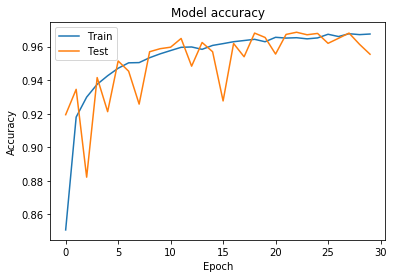

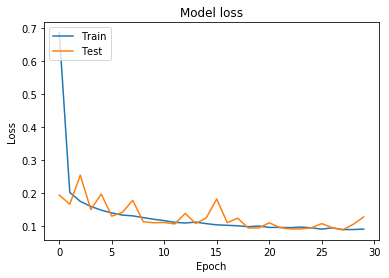

In [0]:
# Plot training & validation accuracy values
plt.plot(historyDense.history['acc'])
plt.plot(historyDense.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyDense.history['loss'])
plt.plot(historyDense.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 917    0    0    0    0    0]
 [   3 4380   12  120    0    0]
 [   0    0 3213  345    0    0]
 [   1   80   95 2875   11    0]
 [ 222    2    0    1  266    0]
 [   0    0    0    0    0 7457]]
Normalized confusion matrix
[[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [6.64e-04 9.70e-01 2.66e-03 2.66e-02 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 9.03e-01 9.70e-02 0.00e+00 0.00e+00]
 [3.27e-04 2.61e-02 3.10e-02 9.39e-01 3.59e-03 0.00e+00]
 [4.52e-01 4.07e-03 0.00e+00 2.04e-03 5.42e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]]


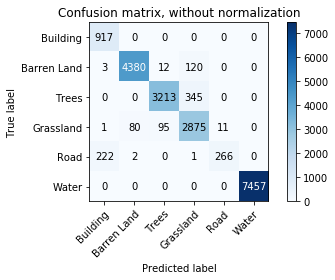

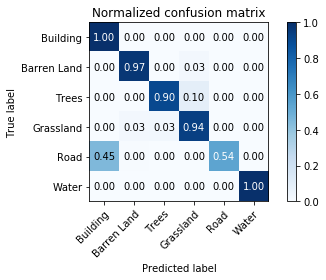

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_predDense, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_predDense, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
predicted_classes = np.argmax((y_predDense),axis=1)
y_test1 = np.argmax(y_test, axis=1)
predicted_classes.shape, y_test.shape
print(classification_report(y_test1, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

    Building       0.80      1.00      0.89       917
 Barren Land       0.98      0.97      0.98      4515
       Trees       0.97      0.90      0.93      3558
   Grassland       0.86      0.94      0.90      3062
        Road       0.96      0.54      0.69       491
       Water       1.00      1.00      1.00      7457

   micro avg       0.96      0.96      0.96     20000
   macro avg       0.93      0.89      0.90     20000
weighted avg       0.96      0.96      0.95     20000



In [0]:
keras.backend.clear_session()

## Convolutional Neural Network

In [0]:
modelConv = Sequential()

modelConv.add(Conv2D(16, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,4)))
modelConv.add(layers.LeakyReLU(alpha=0.1))
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D((2, 2),padding='same'))
modelConv.add(Dropout(0.25))
modelConv.add(Conv2D(32, (3, 3), activation='linear',padding='same'))
modelConv.add(layers.LeakyReLU(alpha=0.1))
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv.add(Dropout(0.25))
modelConv.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
modelConv.add(layers.LeakyReLU(alpha=0.1))                
modelConv.add(BatchNormalization())
modelConv.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv.add(Dropout(0.4))
modelConv.add(Flatten())
modelConv.add(Dense(64, activation='linear'))
modelConv.add(layers.LeakyReLU(alpha=0.1))           
#modelConv.add(BatchNormalization())
#modelConv.add(Dropout(0.3))
modelConv.add(Dense(6, activation='softmax'))

In [0]:
modelConv.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

start = time.clock() 
historyConv = modelConv.fit(X_train_img,y_train,batch_size=64, epochs=20, verbose=1, validation_split=0.1)

end = time.clock()
timeConv = end-start

print("Total Time: {} ".format(timeConv)) 

Train on 90000 samples, validate on 10000 samples
Epoch 1/20
90000/90000 [==============================] - 28s 309us/step - loss: 0.1727 - categorical_accuracy: 0.9358 - val_loss: 0.1649 - val_categorical_accuracy: 0.9316
Epoch 2/20
90000/90000 [==============================] - 26s 294us/step - loss: 0.0923 - categorical_accuracy: 0.9666 - val_loss: 0.1710 - val_categorical_accuracy: 0.9297
Epoch 3/20
90000/90000 [==============================] - 27s 298us/step - loss: 0.0734 - categorical_accuracy: 0.9739 - val_loss: 0.1182 - val_categorical_accuracy: 0.9560
Epoch 4/20
90000/90000 [==============================] - 27s 297us/step - loss: 0.0669 - categorical_accuracy: 0.9765 - val_loss: 0.1359 - val_categorical_accuracy: 0.9448
Epoch 5/20
90000/90000 [==============================] - 26s 294us/step - loss: 0.0607 - categorical_accuracy: 0.9785 - val_loss: 0.1115 - val_categorical_accuracy: 0.9605
Epoch 6/20
90000/90000 [==============================] - 27s 297us/step - loss: 0.05

In [0]:
test_lossConv, test_accConv = modelConv.evaluate(X_test_img, y_test)
print('Test loss:',test_lossConv)
print('Test accuracy:', test_accConv)

# Predicting the Test set results
y_predConv = modelConv.predict(X_test_img, verbose=1)



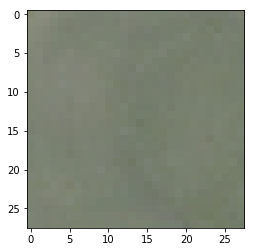

Prediction:
0.0% probability building,
0.0% probability barren land,
0.0% probability trees,
100.0% probability grassland,
0.0% probability road,
0.0% probability water

Ground Truth: Grassland


In [0]:
ix = 321#Type a number between 0 and 999 inclusive
plt.imshow(X_test[ix].reshape(28,28,4), cmap='gray', interpolation='none') #Only seeing the RGB channels
plt.show()
#Tells what the image is
class_names = ['Building','Barren Land','Trees','Grassland','Road','Water']
print ('Prediction:\n{:.1f}% probability building,\n{:.1f}% probability barren land,\n{:.1f}% probability trees,\n{:.1f}% probability grassland,\n{:.1f}% probability road,\n{:.1f}% probability water\n'.format(y_predConv[ix,0]*100,y_predConv[ix,1]*100,y_predConv[ix,2]*100,y_predConv[ix,3]*100,y_predConv[ix,4]*100,y_predConv[ix,5]*100))
print ('Ground Truth: ',end='')
print(class_names[y_test1[ix]])

### Metrics and Visualization NN

In [0]:
plot_model(modelConv, to_file='modelConvSat6.png')
modelConv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1184      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

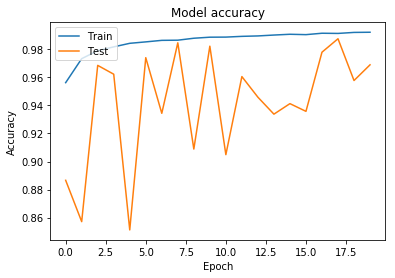

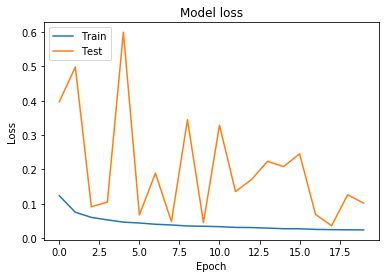

In [0]:
# Plot training & validation accuracy values
plt.plot(historyConv.history['acc'])
plt.plot(historyConv.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyConv.history['loss'])
plt.plot(historyConv.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 654    0    0    0  263    0]
 [   0 4459    0   54    2    0]
 [   0    0 3536   22    0    0]
 [   0  248    2 2812    0    0]
 [   0    0    0    0  491    0]
 [   0    0    0    0    0 7457]]
Normalized confusion matrix
[[7.13e-01 0.00e+00 0.00e+00 0.00e+00 2.87e-01 0.00e+00]
 [0.00e+00 9.88e-01 0.00e+00 1.20e-02 4.43e-04 0.00e+00]
 [0.00e+00 0.00e+00 9.94e-01 6.18e-03 0.00e+00 0.00e+00]
 [0.00e+00 8.10e-02 6.53e-04 9.18e-01 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00]]


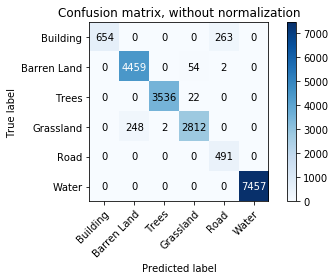

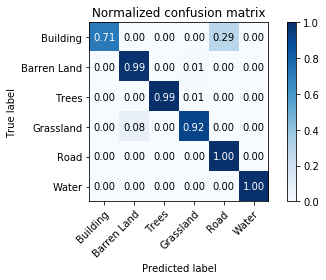

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_predConv, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_predConv, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [0]:
predicted_classes = np.argmax((y_predConv),axis=1)
y_test1 = np.argmax(y_test, axis=1)
predicted_classes.shape, y_test.shape
print(classification_report(y_test1, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

    Building       1.00      0.71      0.83       917
 Barren Land       0.95      0.99      0.97      4515
       Trees       1.00      0.99      1.00      3558
   Grassland       0.97      0.92      0.95      3062
        Road       0.65      1.00      0.79       491
       Water       1.00      1.00      1.00      7457

   micro avg       0.97      0.97      0.97     20000
   macro avg       0.93      0.94      0.92     20000
weighted avg       0.98      0.97      0.97     20000



Found 591 incorrect labels


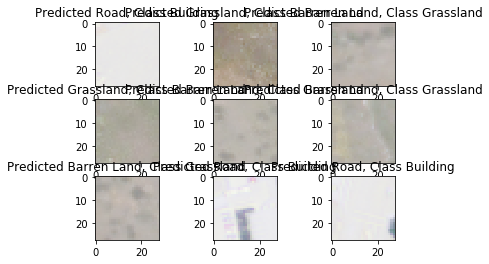

In [0]:
incorrect = np.where(predicted_classes!=y_test1)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28,4), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(class_names[predicted_classes[incorrect]], class_names[y_test1[incorrect]]))
plt.show()

In [0]:
keras.backend.clear_session()

## Comparison

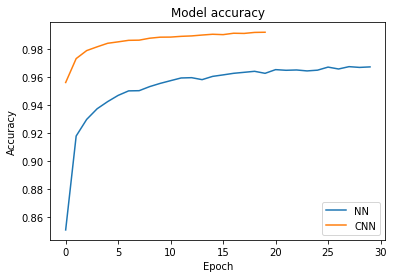

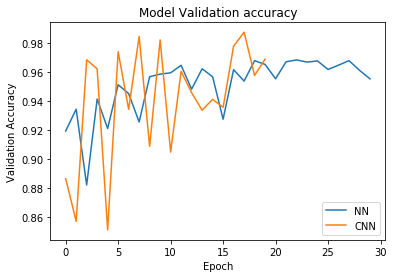

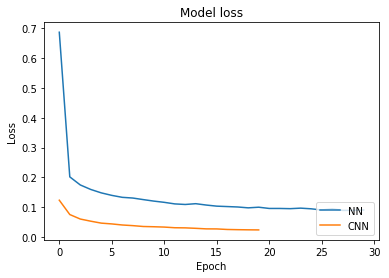

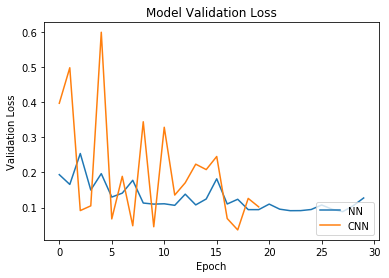

In [0]:
plt.plot(historyDense.history['acc'], label='NN')
plt.plot(historyConv.history['acc'], label='CNN')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()



plt.plot(historyDense.history['val_acc'], label='NN')
plt.plot(historyConv.history['val_acc'], label='CNN')


plt.title('Model Validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyDense.history['loss'], label='NN')
plt.plot(historyConv.history['loss'], label='CNN')


plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyDense.history['val_loss'], label='NN')
plt.plot(historyConv.history['val_loss'], label='CNN')


plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()




In [0]:
plt.scatter(timeDense,1,label='NN')
plt.scatter(timeConv,1,label='CNN')


plt.title('Training time per model')
plt.xlabel('Time (s)')
plt.legend(loc='upper left')
plt.show()

# UC Merced Landuse

### Dataset preparation

In [0]:
SIZE = 100
# resized image size
RESIZED_IMG_SIZE = (64, 64)

In [0]:
agricultural_dir = "UCMerced_LandUse/Images/agricultural/"
airplane_dir = "UCMerced_LandUse/Images/airplane/"
baseballdiamond_dir = "UCMerced_LandUse/Images/baseballdiamond/"
beach_dir = "UCMerced_LandUse/Images/beach/"
buildings_dir = "UCMerced_LandUse/Images/buildings/"
chaparral_dir = "UCMerced_LandUse/Images/chaparral/"
denseresidential_dir = "UCMerced_LandUse/Images/denseresidential/"
forest_dir = "UCMerced_LandUse/Images/forest/"
freeway_dir = "UCMerced_LandUse/Images/freeway/"
golfcourse_dir = "UCMerced_LandUse/Images/golfcourse/"
harbor_dir = "UCMerced_LandUse/Images/golfcourse/"
intersection_dir = "UCMerced_LandUse/Images/intersection/"
mediumresidential_dir = "UCMerced_LandUse/Images/mediumresidential/"
mobilehomepark_dir = "UCMerced_LandUse/Images/mobilehomepark/"
overpass_dir = "UCMerced_LandUse/Images/overpass/"
parkinglot_dir = "UCMerced_LandUse/Images/parkinglot/"
river_dir = "UCMerced_LandUse/Images/river/"
runway_dir = "UCMerced_LandUse/Images/runway/"#
sparseresidential_dir = "UCMerced_LandUse/Images/sparseresidential/"
storagetanks_dir = "UCMerced_LandUse/Images/storagetanks/"
tenniscourt_dir = "UCMerced_LandUse/Images/tenniscourt/"

agricultural_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/agricultural") if x.endswith(".tif")]
airplane_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/airplane") if x.endswith(".tif")]
baseballdiamond_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/baseballdiamond") if x.endswith(".tif")]
beach_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/beach") if x.endswith(".tif")]
buildings_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/buildings") if x.endswith(".tif")]
chaparral_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/chaparral") if x.endswith(".tif")]
denseresidential_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/denseresidential") if x.endswith(".tif")]
forest_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/forest") if x.endswith(".tif")]
freeway_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/freeway") if x.endswith(".tif")]
golfcourse_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/golfcourse") if x.endswith(".tif")]
harbor_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/golfcourse") if x.endswith(".tif")]
intersection_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/intersection") if x.endswith(".tif")]
mediumresidential_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/mediumresidential") if x.endswith(".tif")]
mobilehomepark_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/mobilehomepark") if x.endswith(".tif")]
overpass_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/overpass") if x.endswith(".tif")]
parkinglot_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/parkinglot") if x.endswith(".tif")]
river_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/river") if x.endswith(".tif")]
runway_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/runway") if x.endswith(".tif")]
sparseresidential_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/sparseresidential") if x.endswith(".tif")]
storagetanks_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/storagetanks") if x.endswith(".tif")]
tenniscourt_dirs = [ x for x in os.listdir("UCMerced_LandUse/Images/tenniscourt") if x.endswith(".tif")]

In [0]:
labels = []

for x in os.listdir("UCMerced_LandUse/Images"):
  for y in range(100):
    labels.append(x)

In [0]:
data_1 = np.array([skimage.transform.resize(skimage.io.imread(agricultural_dir + t), RESIZED_IMG_SIZE) for t in agricultural_dirs])
data_2 = np.array([skimage.transform.resize(skimage.io.imread(airplane_dir + t), RESIZED_IMG_SIZE) for t in airplane_dirs])
data_3 = np.array([skimage.transform.resize(skimage.io.imread(baseballdiamond_dir + t), RESIZED_IMG_SIZE) for t in baseballdiamond_dirs])
data_4 = np.array([skimage.transform.resize(skimage.io.imread(beach_dir + t), RESIZED_IMG_SIZE) for t in beach_dirs])
data_5 = np.array([skimage.transform.resize(skimage.io.imread(buildings_dir + t), RESIZED_IMG_SIZE) for t in buildings_dirs])
data_6 = np.array([skimage.transform.resize(skimage.io.imread(chaparral_dir + t), RESIZED_IMG_SIZE) for t in chaparral_dirs])
data_7 = np.array([skimage.transform.resize(skimage.io.imread(denseresidential_dir + t), RESIZED_IMG_SIZE) for t in denseresidential_dirs])
data_8 = np.array([skimage.transform.resize(skimage.io.imread(forest_dir + t), RESIZED_IMG_SIZE) for t in forest_dirs])
data_9 = np.array([skimage.transform.resize(skimage.io.imread(freeway_dir + t), RESIZED_IMG_SIZE) for t in freeway_dirs])
data_10 = np.array([skimage.transform.resize(skimage.io.imread(golfcourse_dir + t), RESIZED_IMG_SIZE) for t in golfcourse_dirs])
data_11 = np.array([skimage.transform.resize(skimage.io.imread(harbor_dir + t), RESIZED_IMG_SIZE) for t in harbor_dirs])
data_12 = np.array([skimage.transform.resize(skimage.io.imread(intersection_dir + t), RESIZED_IMG_SIZE) for t in intersection_dirs])
data_13 = np.array([skimage.transform.resize(skimage.io.imread(mediumresidential_dir + t), RESIZED_IMG_SIZE) for t in mediumresidential_dirs])
data_14 = np.array([skimage.transform.resize(skimage.io.imread(mobilehomepark_dir + t), RESIZED_IMG_SIZE) for t in mobilehomepark_dirs])
data_15 = np.array([skimage.transform.resize(skimage.io.imread(overpass_dir + t), RESIZED_IMG_SIZE) for t in overpass_dirs])
data_16 = np.array([skimage.transform.resize(skimage.io.imread(parkinglot_dir + t), RESIZED_IMG_SIZE) for t in parkinglot_dirs])
data_17 = np.array([skimage.transform.resize(skimage.io.imread(river_dir + t), RESIZED_IMG_SIZE) for t in river_dirs])
data_18 = np.array([skimage.transform.resize(skimage.io.imread(runway_dir + t), RESIZED_IMG_SIZE) for t in runway_dirs])
data_19 = np.array([skimage.transform.resize(skimage.io.imread(sparseresidential_dir + t), RESIZED_IMG_SIZE) for t in sparseresidential_dirs])
data_20 = np.array([skimage.transform.resize(skimage.io.imread(storagetanks_dir + t), RESIZED_IMG_SIZE) for t in storagetanks_dirs])
data_21 = np.array([skimage.transform.resize(skimage.io.imread(tenniscourt_dir + t), RESIZED_IMG_SIZE) for t in tenniscourt_dirs])

data = np.concatenate((data_1, data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,
                       data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21))


# these variables are no longer needed, deleting them to free memory
#del data_1, data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, shuffle=True)

In [0]:
train_small_with_dummies = pd.get_dummies(y_train, sparse=True)
from keras.utils import to_categorical
y_train1 = to_categorical(train_small_with_dummies)

train_small_with_dummies2 = pd.get_dummies(y_valid, sparse=True)
from keras.utils import to_categorical
y_valid1 = to_categorical(train_small_with_dummies2)

### Data Augmentation

In [0]:
train_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)

train_generator.fit(x_train)

evaluate_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)
evaluate_generator.fit(x_valid)

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
)

### CNN 35-Layer Data Augmentation Model

In [0]:
modelConv1 = Sequential()


modelConv1.add(SeparableConv2D(64, 3, padding="same", depth_multiplier=16, input_shape=(64, 64, 3)))
modelConv1.add(SpatialDropout2D(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(MaxPooling2D())
modelConv1.add(Conv2D(128, 3, padding="same"))
modelConv1.add(SpatialDropout2D(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(MaxPooling2D())
modelConv1.add(Conv2D(128, 3, padding="same"))
modelConv1.add(SpatialDropout2D(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(MaxPooling2D())
modelConv1.add(Conv2D(128, 3, padding="same"))
modelConv1.add(SpatialDropout2D(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(MaxPooling2D())
modelConv1.add(Conv2D(256, 2, padding="same"))
modelConv1.add(SpatialDropout2D(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(MaxPooling2D())
modelConv1.add(Flatten())
modelConv1.add(Dense(128))
modelConv1.add(Dropout(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(Dense(32))
modelConv1.add(Dropout(0.25))
modelConv1.add(BatchNormalization(momentum=0.99))
modelConv1.add(LeakyReLU(alpha=0.15))
modelConv1.add(Dense(21, activation="softmax"))



In [0]:
modelConv1.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
x_train.shape,y_train1.shape

((1837, 64, 64, 3), (1837, 21, 2))

In [0]:
start = time.clock() 

historyConv1 = modelConv1.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

end = time.clock()
timeConv1 = end-start

print("Total Time: {} ".format(timeConv1)) 

Epoch 1/256
 - 4s - loss: 3.0759 - acc: 0.1042 - val_loss: 2.9650 - val_acc: 0.1159
Epoch 2/256
 - 4s - loss: 2.9755 - acc: 0.0990 - val_loss: 3.0958 - val_acc: 0.1204
Epoch 3/256
 - 4s - loss: 2.9885 - acc: 0.1198 - val_loss: 3.0500 - val_acc: 0.1639
Epoch 4/256
 - 4s - loss: 2.9099 - acc: 0.1458 - val_loss: 2.7629 - val_acc: 0.1823
Epoch 5/256
 - 4s - loss: 2.7832 - acc: 0.1719 - val_loss: 2.6712 - val_acc: 0.1892
Epoch 6/256
 - 4s - loss: 2.7393 - acc: 0.1979 - val_loss: 2.6465 - val_acc: 0.1970
Epoch 7/256
 - 4s - loss: 2.8175 - acc: 0.1771 - val_loss: 2.6277 - val_acc: 0.1941
Epoch 8/256
 - 4s - loss: 2.7655 - acc: 0.1771 - val_loss: 2.6209 - val_acc: 0.1794
Epoch 9/256
 - 4s - loss: 2.5877 - acc: 0.2135 - val_loss: 2.6163 - val_acc: 0.1717
Epoch 10/256
 - 4s - loss: 2.5971 - acc: 0.2470 - val_loss: 2.6360 - val_acc: 0.1738
Epoch 11/256
 - 4s - loss: 2.7034 - acc: 0.1823 - val_loss: 2.6244 - val_acc: 0.1730
Epoch 12/256
 - 4s - loss: 2.5889 - acc: 0.2188 - val_loss: 2.5754 - val_a

In [0]:
test_lossConv1, test_accConv1 = modelConv1.evaluate(x_valid, train_small_with_dummies2)
print('Test loss:',test_lossConv1)
print('Test accuracy:', test_accConv1)

# Predicting the Test set results
y_predConv1 = modelConv1.predict(x_valid, verbose=1)

263/263 [==============================] - 1s 3ms/step
Test loss: 3.0426965865798774
Test accuracy: 0.045627376425855515
263/263 [==============================] - 0s 1ms/step


In [0]:
keras.backend.clear_session()

#### Metrics and Visualization NN

In [0]:
plot_model(modelConv1, to_file='modelConvMerced.png')
modelConv1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 64, 64, 64)        3568      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 32, 32, 128)       0         
__________

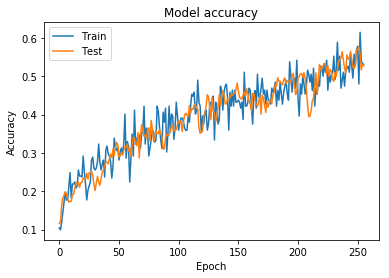

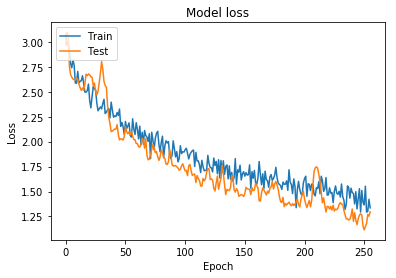

In [0]:
# Plot training & validation accuracy values
plt.plot(historyConv1.history['acc'])
plt.plot(historyConv1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyConv1.history['loss'])
plt.plot(historyConv1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN 20-Layers Without Data Augmentation 

In [0]:
modelConv2 = Sequential()
modelConv2.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(64,64,3)))
modelConv2.add(layers.LeakyReLU(alpha=0.1))
modelConv2.add(BatchNormalization())
modelConv2.add(MaxPooling2D((2, 2),padding='same'))
modelConv2.add(Dropout(0.5))
modelConv2.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
modelConv2.add(layers.LeakyReLU(alpha=0.1))
modelConv2.add(BatchNormalization())
modelConv2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv2.add(Dropout(0.5))
modelConv2.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
modelConv2.add(layers.LeakyReLU(alpha=0.1))                
modelConv2.add(BatchNormalization())
modelConv2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelConv2.add(Dropout(0.5))
modelConv2.add(Flatten())
modelConv2.add(Dense(128, activation='linear'))
modelConv2.add(layers.LeakyReLU(alpha=0.1))           
"""modelConv2.add(BatchNormalization())
modelConv2.add(Dropout(0.5))"""
modelConv2.add(Dense(21, activation='softmax'))

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fde621006a0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 121954960


In [0]:
modelConv2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


start = time.clock() 
history2 = modelConv2.fit(x_train, train_small_with_dummies, validation_data=(x_valid, train_small_with_dummies2),
                  batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeConv2 = end-start

print("Total Time: {} ".format(timeConv2)) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fde621e3cf8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 1140084120


Train on 1680 samples, validate on 420 samples
Epoch 1/256
 - 2s - loss: 6.4648 - acc: 0.1417 - val_loss: 4.8503 - val_acc: 0.1429
Epoch 2/256
 - 1s - loss: 4.3241 - acc: 0.2613 - val_loss: 4.2082 - val_acc: 0.2667
Epoch 3/256
 - 1s - loss: 2.9046 - acc: 0.3643 - val_loss: 3.0245 - val_acc: 0.3119
Epoch 4/256
 - 1s - loss: 1.9683 - acc: 0.4119 - val_loss: 3.1159 - val_acc: 0.3214
Epoch 5/256
 - 1s - loss: 1.6334 - acc: 0.4780 - val_loss: 4.5771 - val_acc: 0.2429
Epoch 6/256
 - 1s - loss: 1.4251 - acc: 0.5345 - val_loss: 5.1768 - val_acc: 0.2524
Epoch 7/256
 - 1s - loss: 1.2872 - acc: 0.5810 - val_loss: 3.3039 - val_acc: 0.3548
Epoch 8/256
 - 1s - loss: 1.1769 - acc: 0.6226 - val_loss: 4.7402 - val_acc: 0.2548
Epoch 9/256
 - 1s - loss: 1.0823 - acc: 0.6232 - val_loss: 4.4984 - val_acc: 0.2952
Epoch 10/256
 - 1s - loss: 0.9357 - acc: 0.6845 - val_loss: 5.3113 - val_acc: 0.2762
Epoch 11/256
 - 1s - loss: 0.8904 - acc: 0.7083 - val_loss: 3.2376 - val_acc: 0.3857
Epoch 12/256
 - 1s - loss: 

In [0]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (64, 64, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('mosquito/mosquitoImages/8B/jun2015-mar2017.png')
y_predConv = modelConv2.predict(image)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
y_predConv

array([[0.0000000e+00, 1.2163700e-12, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.4306950e-35,
        0.0000000e+00, 1.4176312e-38, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [0]:
print ('Prediction:\n{:.1f}% probability building,\n{:.1f}% probability barren land,\n{:.1f}% probability trees,\n{:.1f}% probability grassland,\n{:.1f}% probability road,\n{:.1f}% probability water\n'.format(y_predConv[0,0]*100,y_predConv[0,1]*100,y_predConv[0,2]*100,y_predConv[0,3]*100,y_predConv[0,4]*100,y_predConv[0,7]*100))

Prediction:
0.0% probability building,
0.0% probability barren land,
0.0% probability trees,
0.0% probability grassland,
0.0% probability road,
0.0% probability water



In [0]:
#keras.backend.clear_session()

#### Metrics and Visualization NN

In [0]:
plot_model(modelConv2, to_file='modelConv2Merced.png')
modelConv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
__________

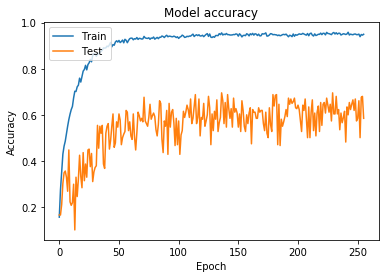

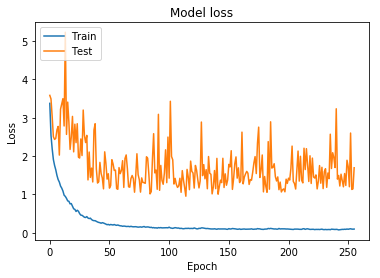

In [0]:
# Plot training & validation accuracy values
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN 20-Layers With Data Augmentation

In [0]:
modelConv2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


start = time.clock() 

history2_1 = modelConv2.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

end = time.clock()
timeConv2_1 = end-start

print("Total Time: {} ".format(timeConv2_1)) 

Epoch 1/256
 - 5s - loss: 4.1580 - acc: 0.0781 - val_loss: 3.5591 - val_acc: 0.1143
Epoch 2/256
 - 5s - loss: 3.4478 - acc: 0.1302 - val_loss: 4.1269 - val_acc: 0.0982
Epoch 3/256
 - 4s - loss: 3.2156 - acc: 0.1406 - val_loss: 4.3976 - val_acc: 0.0838
Epoch 4/256
 - 4s - loss: 3.1664 - acc: 0.2031 - val_loss: 4.2129 - val_acc: 0.0982
Epoch 5/256
 - 4s - loss: 3.1427 - acc: 0.1667 - val_loss: 4.0686 - val_acc: 0.1174
Epoch 6/256
 - 4s - loss: 2.9825 - acc: 0.1719 - val_loss: 3.9243 - val_acc: 0.1300
Epoch 7/256
 - 4s - loss: 2.7062 - acc: 0.2500 - val_loss: 4.2207 - val_acc: 0.1185
Epoch 8/256
 - 4s - loss: 2.9631 - acc: 0.2240 - val_loss: 4.1831 - val_acc: 0.1161
Epoch 9/256
 - 4s - loss: 2.9222 - acc: 0.1979 - val_loss: 4.1876 - val_acc: 0.1137
Epoch 10/256
 - 4s - loss: 2.5528 - acc: 0.2642 - val_loss: 3.9361 - val_acc: 0.1212
Epoch 11/256
 - 4s - loss: 2.5912 - acc: 0.2240 - val_loss: 3.7251 - val_acc: 0.1463
Epoch 12/256
 - 4s - loss: 2.4672 - acc: 0.2604 - val_loss: 3.6799 - val_a

In [0]:
keras.backend.clear_session()

#### Metrics and Visualization NN

In [0]:
plot_model(modelConv2, to_file='modelConv2Merced2.png')
modelConv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
__________

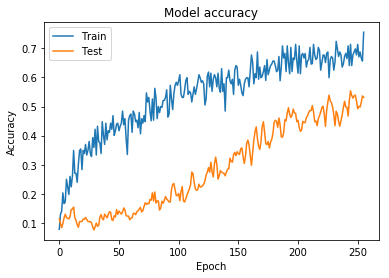

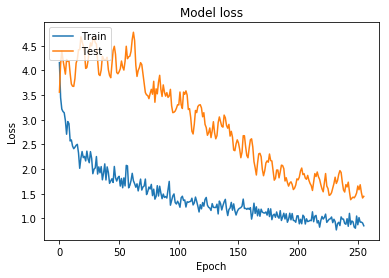

In [0]:
# Plot training & validation accuracy values
plt.plot(history2_1.history['acc'])
plt.plot(history2_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Transfer Learning VGG19

In [0]:
base_modelVgg19=VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(64,64,3))

modelTransf = Sequential()

modelTransf.add(base_modelVgg19)
modelTransf.add(Flatten())
modelTransf.add(BatchNormalization())
modelTransf.add(Dense(128, activation='linear'))
modelTransf.add(layers.LeakyReLU(alpha=0.1))           
modelTransf.add(Dropout(0.3))
modelTransf.add(Dense(21, activation='softmax'))
modelTransf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
start = time.clock() 
historyConvTransf = modelTransf.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeConvTL = end-start

print("Total Time: {} ".format(timeConvTL)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1680 samples, validate on 420 samples
Epoch 1/256
 - 8s - loss: 2.9710 - acc: 0.0845 - val_loss: 15.3889 - val_acc: 0.0452
Epoch 2/256
 - 3s - loss: 2.7135 - acc: 0.0929 - val_loss: 15.2738 - val_acc: 0.0524
Epoch 3/256
 - 3s - loss: 2.6819 - acc: 0.0982 - val_loss: 15.6192 - val_acc: 0.0310
Epoch 4/256
 - 3s - loss: 2.6146 - acc: 0.1214 - val_loss: 15.3889 - val_acc: 0.0452
Epoch 5/256
 - 3s - loss: 2.5701 - acc: 0.1345 - val_loss: 15.3889 - val_acc: 0.0452
Epoch 6/256
 - 3s - loss: 2.5383 - acc: 0.1393 - val_loss: 5.8011 - val_acc: 0.0929
Epoch 7/256
 - 3s - loss: 2.4705 - acc: 0.1601 - val_loss: 10.4263 - val_acc: 0.0667
Epoch 8/256
 - 3s - loss: 2.4565 - acc: 0.1476 - val_loss: 11.7171 - val_acc: 0.0595
Epoch 9/256
 - 3s - loss: 2.4112 - acc: 0.1554 - val_loss: 7.7097 - val_acc: 0.0857
Epoch 10/256
 - 3s - loss: 2.3856 - acc: 0.1714 - val_loss: 13.7657 - val_acc: 0.0167
Epoch 11/256
 - 3s - loss: 2.3789 - acc: 0.1720 - val_loss: 15.0819 - val_acc: 0.0643
Epoch 12/256
 - 3s

In [0]:
historyConvTransfDA = modelTransf.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

#### Metrics and Visualization NN

In [0]:
plot_model(modelTransf, to_file='modelTransf3.png')
modelTransf.summary()

In [0]:
# Plot training & validation accuracy values
plt.plot(historyConvTransf.history['acc'])
plt.plot(historyConvTransf.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyConvTransf.history['loss'])
plt.plot(historyConvTransf.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Transfer Learning ResNet

In [0]:
modelTransf2=ResNet50(weights=None,
                      include_top=True,
                      classes=21,
                      input_shape=(64,64,3))

'''modelTransf2 = Sequential()


modelTransf2.add(base_modelRes)
modelTransf2.add(Flatten())
modelTransf2.add(BatchNormalization())
modelTransf2.add(Dense(128, activation='linear'))
modelTransf2.add(layers.LeakyReLU(alpha=0.1))           
modelTransf2.add(Dropout(0.3))
modelTransf2.add(Dense(21, activation='softmax'))'''

modelTransf2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [0]:
#ResNet50 Vainilla
start = time.clock() 
historyRes = modelTransf2.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 1680 samples, validate on 420 samples
Epoch 1/256
 - 20s - loss: 3.5055 - categorical_accuracy: 0.1065 - val_loss: 12.9026 - val_categorical_accuracy: 0.0500
Epoch 2/256
 - 3s - loss: 2.8112 - categorical_accuracy: 0.2530 - val_loss: 4.4494 - val_categorical_accuracy: 0.1071
Epoch 3/256
 - 3s - loss: 1.9699 - categorical_accuracy: 0.4071 - val_loss: 2.9557 - val_categorical_accuracy: 0.2476
Epoch 4/256
 - 3s - loss: 1.4065 - categorical_accuracy: 0.6000 - val_loss: 2.7085 - val_categorical_accuracy: 0.3262
Epoch 5/256
 - 3s - loss: 0.9851 - categorical_accuracy: 0.7125 - val_loss: 2.3536 - val_categorical_accuracy: 0.3238
Epoch 6/256
 - 3s - loss: 0.9595 - categorical_accuracy: 0.7107 - val_loss: 3.1489 - val_categorical_accuracy: 0.2833
Epoch 7/256
 - 3s - loss: 1.3484 - categorical_accuracy: 0.5935 - val_loss: 14.8475 - val_categorical_accuracy: 0.0524
Epoch 8/256
 - 3s - loss: 1.1386 - categorical_accuracy: 0.6643 - val_loss: 10.4661 - val_categorical_accuracy: 0.1071
Epoch

In [0]:
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

Epoch 1/256
 - 23s - loss: 3.3398 - acc: 0.2031 - val_loss: 5.3168 - val_acc: 0.2534
Epoch 2/256
 - 5s - loss: 2.7254 - acc: 0.3542 - val_loss: 7.9000 - val_acc: 0.2084
Epoch 3/256
 - 5s - loss: 2.5293 - acc: 0.3490 - val_loss: 7.7688 - val_acc: 0.2612
Epoch 4/256
 - 5s - loss: 2.3101 - acc: 0.3646 - val_loss: 5.9448 - val_acc: 0.3007
Epoch 5/256
 - 5s - loss: 2.2501 - acc: 0.4010 - val_loss: 4.3910 - val_acc: 0.2937
Epoch 6/256
 - 6s - loss: 2.4885 - acc: 0.4271 - val_loss: 6.8921 - val_acc: 0.1907
Epoch 7/256
 - 5s - loss: 2.5360 - acc: 0.4010 - val_loss: 9.0034 - val_acc: 0.1200
Epoch 8/256
 - 5s - loss: 2.7296 - acc: 0.3906 - val_loss: 7.0437 - val_acc: 0.1376
Epoch 9/256
 - 5s - loss: 2.5865 - acc: 0.3360 - val_loss: 12.2159 - val_acc: 0.0786
Epoch 10/256
 - 5s - loss: 2.5090 - acc: 0.3958 - val_loss: 14.1588 - val_acc: 0.0315
Epoch 11/256
 - 5s - loss: 3.2651 - acc: 0.2552 - val_loss: 15.4258 - val_acc: 0.0315
Epoch 12/256
 - 6s - loss: 2.8837 - acc: 0.2760 - val_loss: 15.3174 - 

#### Metrics and Visualization NN

In [0]:
plot_model(modelTransf2, to_file='modelTransf4.png')
modelTransf2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

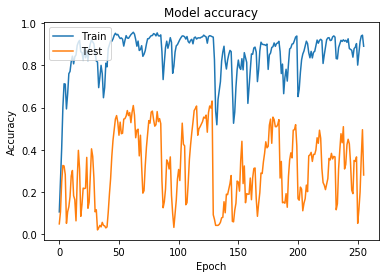

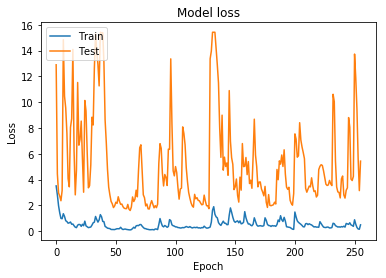

In [0]:
# Plot training & validation accuracy values
plt.plot(historyRes.history['categorical_accuracy'])
plt.plot(historyRes.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyRes.history['loss'])
plt.plot(historyRes.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

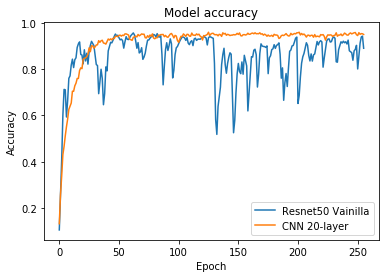

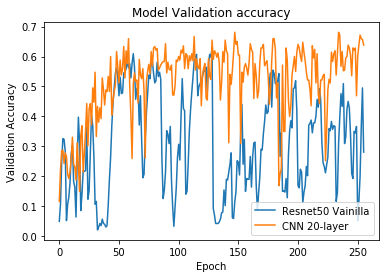

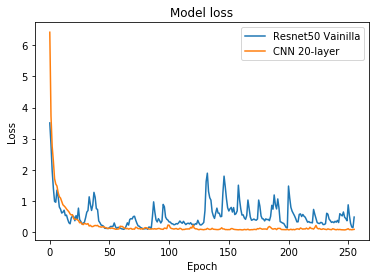

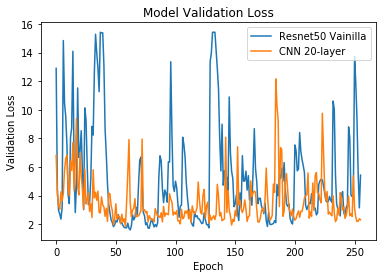

In [0]:
plt.plot(historyRes.history['categorical_accuracy'], label='Resnet50 Vainilla')
plt.plot(history2.history['acc'], label='CNN 20-layer')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()



plt.plot(historyRes.history['val_categorical_accuracy'], label='Resnet50 Vainilla')
plt.plot(history2.history['val_acc'], label='CNN 20-layer')


plt.title('Model Validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyRes.history['loss'], label='Resnet50 Vainilla')
plt.plot(history2.history['loss'], label='CNN 20-layer')


plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.show()


plt.plot(historyRes.history['val_loss'], label='Resnet50 Vainilla')
plt.plot(history2.history['val_loss'], label='CNN 20-layer')


plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.show()




### Comparison

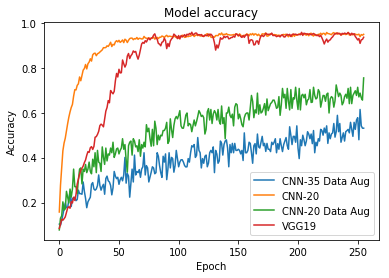

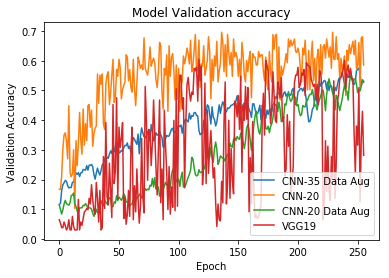

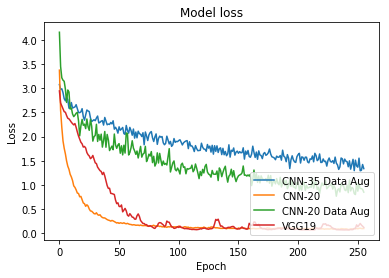

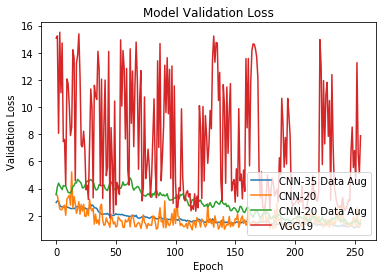

In [0]:
plt.plot(historyConv1.history['acc'], label='CNN-35 Data Aug')
plt.plot(history2.history['acc'], label='CNN-20')
plt.plot(history2_1.history['acc'], label='CNN-20 Data Aug')
plt.plot(historyConvTransf.history['acc'], label='VGG19')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()



plt.plot(historyConv1.history['val_acc'], label='CNN-35 Data Aug')
plt.plot(history2.history['val_acc'], label='CNN-20')
plt.plot(history2_1.history['val_acc'], label='CNN-20 Data Aug')
plt.plot(historyConvTransf.history['val_acc'], label='VGG19')

plt.title('Model Validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend( loc='lower right')
plt.show()


plt.plot(historyConv1.history['loss'], label='CNN-35 Data Aug')
plt.plot(history2.history['loss'], label='CNN-20')
plt.plot(history2_1.history['loss'], label='CNN-20 Data Aug')
plt.plot(historyConvTransf.history['loss'], label='VGG19')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.show()


plt.plot(historyConv1.history['val_loss'], label='CNN-35 Data Aug')
plt.plot(history2.history['val_loss'], label='CNN-20')
plt.plot(history2_1.history['val_loss'], label='CNN-20 Data Aug')
plt.plot(historyConvTransf.history['val_loss'], label='VGG19')

plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.show()




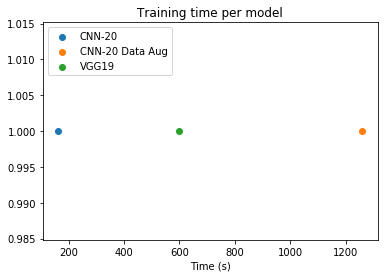

In [0]:
#plt.scatter(timeConv1,1,label='CNN-35')
plt.scatter(timeConv2,1,label='CNN-20')
plt.scatter(timeConv2_1,1,label='CNN-20 Data Aug')
plt.scatter(timeConvTL,1,label='VGG19')

plt.title('Training time per model')
plt.xlabel('Time (s)')
plt.legend(loc='upper left')
plt.show()

# Malaria Classifier

## Load data

In [0]:
# number of infected or uninfected pictures
SIZE = 13779

# resized image size
RESIZED_IMG_SIZE = (32, 32)
INFECTED_DIR = "cell_images/Parasitized/"
UNINFECTED_DIR = "cell_images/Uninfected/"
INFECTED_DIRS = [ x for x in os.listdir("cell_images/Parasitized/") if x.endswith(".png")]
UNINFECTED_DIRS = [ x for x in os.listdir("cell_images/Uninfected/") if x.endswith(".png")]


In [0]:
labels = np.ones(2*SIZE)    # Infected cells label = 1
labels[:SIZE] = 0.0         # Uninfected cells label = 0
print("Label assignment successful")

Label assignment successful


In [0]:
data_u = np.array([skimage.transform.resize(skimage.io.imread(UNINFECTED_DIR + t), RESIZED_IMG_SIZE) for t in UNINFECTED_DIRS])
data_i = np.array([skimage.transform.resize(skimage.io.imread(INFECTED_DIR + t), RESIZED_IMG_SIZE) for t in INFECTED_DIRS])
# concatenating the two arrays to get the final dataset.
data = np.concatenate((data_u, data_i))
print("Images loaded successfully")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(data, labels, test_size=0.125, shuffle=True)

NameError: ignored

## Data Augmentation

In [0]:
train_generator = kr.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True
    )
train_generator.fit(x_train)
evaluate_generator = kr.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True
    )
evaluate_generator.fit(x_valid)
print("Data split into train and validation sets successfully")

## Model Architecture

In [0]:
modelMal = Sequential()


modelMal.add(SeparableConv2D(64, 3, padding="same", depth_multiplier=16, input_shape=(64, 64, 3)))
modelMal.add(SpatialDropout2D(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(MaxPooling2D())
modelMal.add(Conv2D(128, 3, padding="same"))
modelMal.add(SpatialDropout2D(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(MaxPooling2D())
modelMal.add(Conv2D(128, 3, padding="same"))
modelMal.add(SpatialDropout2D(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(MaxPooling2D())
modelMal.add(Conv2D(128, 3, padding="same"))
modelMal.add(SpatialDropout2D(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(MaxPooling2D())
modelMal.add(Conv2D(256, 2, padding="same"))
modelMal.add(SpatialDropout2D(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(MaxPooling2D())
modelMal.add(Flatten())
modelMal.add(Dense(128))
modelMal.add(Dropout(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(Dense(32))
modelMal.add(Dropout(0.25))
modelMal.add(BatchNormalization(momentum=0.99))
modelMal.add(LeakyReLU(alpha=0.15))
modelMal.add(Dense(21, activation="softmax"))

In [0]:
modelMal.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
x_train.shape,y_train.shape

In [0]:
start = time.clock() 

historyMal = modelMal.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

end = time.clock()
timeMal = end-start

print("Total Time: {} ".format(timeMal)) 

In [0]:
test_lossMal, test_accMal = modelConv1.evaluate(x_valid, train_small_with_dummies2)
print('Test loss:',test_lossMal)
print('Test accuracy:', test_accMal)

# Predicting the Test set results
y_predMal = modelMal.predict(x_valid, verbose=1)

#### Metrics and Visualization NN

In [0]:
plot_model(modelMal, to_file='modelMal.png')
modelMal.summary()

In [0]:
# Plot training & validation accuracy values
plt.plot(historyMal.history['acc'])
plt.plot(historyMal.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyMal.history['loss'])
plt.plot(historyMal.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Heat Map experiments

## Transfer Learning Model

574717952/574710816 [==============================] - 7s 0us/step


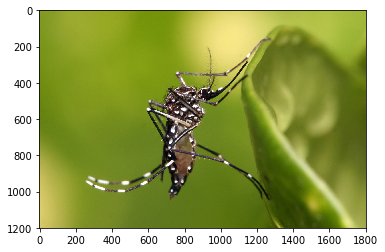

In [0]:
model = VGG19(weights='imagenet')
img_path = 'Aedes_aegypti.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

In [0]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x.shape
x = preprocess_input(x)

preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])

InvalidArgumentError: ignored

Text(0.5, 1.0, 'Top 3 Predictions:')

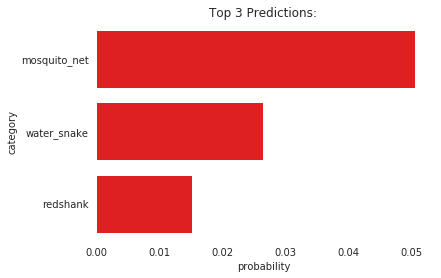

In [0]:
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

In [0]:
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

ValueError: ignored

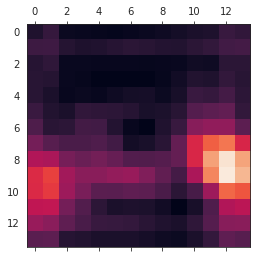

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = .8
superimposed_img = heatmap * hif + img
output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

Text(0.5, 1.0, 'mosquito_net')

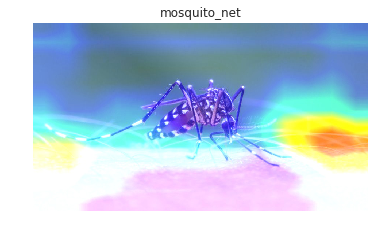

In [0]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

## Heatmap Function

In [0]:
def cam(img_path):
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [0]:
cam('Aedes_aegypti.jpg')

NameError: ignored

# Image Slicer

In [0]:
####CAREFUL####
####CAREFUL####
####CAREFUL####

os.chdir('/content/drive/My Drive/testImages')
for x in range(5):
  tiles = image_slicer.slice('imageFile'+str(x+5)+'.JPG', 150)

  for tile in tiles:
    overlay = ImageDraw.Draw(tile.image)
    overlay.text((5, 5), str(tile.number), (255, 255, 255),
                 ImageFont.load_default())

  image_slicer.save_tiles(tiles)

# Sources


1.  National Aeronautics and Space Administration. NASA Worldview. http://aiweb.techfak.uni-bielefeld.de/ content/bworld-robot-control-software/ (2019). [Online; accessed 01-May-2019].
2.  National Aeronautics and Space Administration. World of Change: Amazon Deforestation. https: //earthobservatory.nasa.gov/world-of-change/Deforestation/ (2019). [Online; accessed 29-April-2019].
3. Rita Ko. United Nations: USA for UNHCR Launches Satellite Imagery and Crowdsourcing
Project to Improve Refugee Camp Planning and Maintenance. https://www.unrefugees.org/news/ usa-for-unhcr-launches-satellite-imagery-and-crowdsourcing-project-to-improve-refugee-camp-planning-and-maintenance/ (2019). [Online; accessed 01-May-2019].
4. NVIDIA News Center. AI Helps Detect Disaster Damage From Satellite Imagery. https://news.developer. nvidia.com/ai-helps-detect-disaster-damage-from-satellite-imagery/ (2018). [Online; accessed 29-April- 2019].
5. He, K., Zhang, X., Ren, S. & Sun, J. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition, 770–778 (2016).
6. Basu, S. et al. Deepsat - A learning framework for satellite imagery. CoRR abs/1509.03602 (2015). 1509.03602.
7. Simonyan, K. & Zisserman, A. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556 (2014).
8. Saikat Basu, Sangram Ganguly, Supratik Mukhopadhyay, Robert Dibiano, Manohar Karki and Ramakrishna Nemani, DeepSat - A Learning framework for Satellite Imagery, ACM SIGSPATIAL 2015.
